<a href="https://colab.research.google.com/github/amantiwari1/Notebook_List/blob/master/Dog_Cat_Classfication_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os 
os.environ["KAGGLE_USERNAME"] = "amantiwari78632"
os.environ["KAGGLE_KEY"] = "1e1da0d143b060ea260287af5ec19d5b"
!kaggle competitions download -c dogs-vs-cats 

 95% 515M/543M [00:04<00:00, 130MB/s]
100% 543M/543M [00:04<00:00, 133MB/s]
 97% 263M/271M [00:02<00:00, 99.3MB/s]
100% 271M/271M [00:02<00:00, 103MB/s] 
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 78.0MB/s]


In [0]:
!unzip train.zip
!unzip test1.zip


In [4]:
import os
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split 

Using TensorFlow backend.


In [0]:
FAST_RUN = False
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH,IMAGE_HEIGHT)
IMAGE_CHANNEL = 3

In [6]:
filenames = os.listdir("/content/train")
category = []
for filename in filenames:
  name = filename.split(".")[0]
  if name == "cat":
    category.append(0)
  else:
    category.append(1)

df = pd.DataFrame({"filename":filenames, "category":category})

df.head()


,filename,category
0,dog.4883.jpg,1
1,cat.11230.jpg,0
2,dog.886.jpg,1
3,dog.4689.jpg,1
4,cat.9829.jpg,0


In [7]:
df.tail()

,filename,category
24995,cat.3493.jpg,0
24996,dog.11367.jpg,1
24997,dog.1361.jpg,1
24998,cat.4321.jpg,0
24999,cat.5883.jpg,0


In [0]:
#!pip install keras==2.3.0

In [9]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,Dropout,BatchNormalization,MaxPooling2D

model = Sequential()

model.add(Conv2D(32,(3,3), activation="relu", input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNEL)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.5))

model.add(Conv2D(64,(3,3),activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.5))

model.add(Conv2D(128,(3,3),activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(BatchNormalization())
model.add(Dense(2,activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

In [0]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early = EarlyStopping(patience=10)
reduc = ReduceLROnPlateau(monitor="val_acc",patience=2,verbose=1,factor=0.5,min_lr=0.00001)

callbacks = [early, reduc]

In [11]:
df["category"] = df["category"].replace({0:"cat",1:"dog"})
df.head() 

,filename,category
0,dog.4883.jpg,dog
1,cat.11230.jpg,cat
2,dog.886.jpg,dog
3,dog.4689.jpg,dog
4,cat.9829.jpg,cat


In [0]:
df_train , df_val = train_test_split(df,test_size=0.20,random_state=42)

In [0]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [0]:
total_train = df_train.shape[0]
total_validate = df_val.shape[0]
batch_size=15

In [15]:
image = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_gen = image.flow_from_dataframe(
    df_train,
    "/content/train",
    x_col="filename",
    y_col="category",
    target_size = IMAGE_SIZE,
    class_mode ="categorical",
    batch_size=batch_size 
)

Found 20000 validated image filenames belonging to 2 classes.


In [16]:
image1 = ImageDataGenerator(
    rescale=1./255
)

val_gen = image1.flow_from_dataframe(
    df_val,
    "/content/train",
    x_col="filename",
    y_col="category",
    target_size = IMAGE_SIZE,
    class_mode ="categorical",
    batch_size=batch_size 
)

Found 5000 validated image filenames belonging to 2 classes.


In [0]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [18]:

history = model.fit_generator(train_gen,
                    epochs=15,
                    validation_data=val_gen,
                    validation_steps=total_validate//batch_size,
                    steps_per_epoch=total_train//batch_size,
                    callbacks=callbacks)

Epoch 1/15
1333/1333 [==============================] - 134s 101ms/step - loss: 0.7099 - accuracy: 0.6187 - val_loss: 0.5822 - val_accuracy: 0.6300
Epoch 2/15
   2/1333 [..............................] - ETA: 1:24 - loss: 0.6397 - accuracy: 0.5667

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1333/1333 [==============================] - 129s 97ms/step - loss: 0.5776 - accuracy: 0.6981 - val_loss: 0.8742 - val_accuracy: 0.6989
Epoch 3/15
1333/1333 [==============================] - 129s 97ms/step - loss: 0.5332 - accuracy: 0.7335 - val_loss: 0.7313 - val_accuracy: 0.6694
Epoch 4/15
1333/1333 [==============================] - 129s 96ms/step - loss: 0.5027 - accuracy: 0.7518 - val_loss: 0.6021 - val_accuracy: 0.6965
Epoch 5/15
1333/1333 [==============================] - 130s 97ms/step - loss: 0.4786 - accuracy: 0.7720 - val_loss: 0.3488 - val_accuracy: 0.7673
Epoch 6/15
1333/1333 [==============================] - 129s 97ms/step - loss: 0.4638 - accuracy: 0.7850 - val_loss: 0.2606 - val_accuracy: 0.8132
Epoch 7/15
1333/1333 [==============================] - 130s 97ms/step - loss: 0.4492 - accuracy: 0.7913 - val_loss: 0.3355 - val_accuracy: 0.7366
Epoch 8/15
1333/1333 [==============================] - 129s 97ms/step - loss: 0.4419 - accuracy: 0.7981 - val_loss: 0.4300 - val

In [0]:
model.save("/content/drive/My Drive/BCA/cnn.h5")

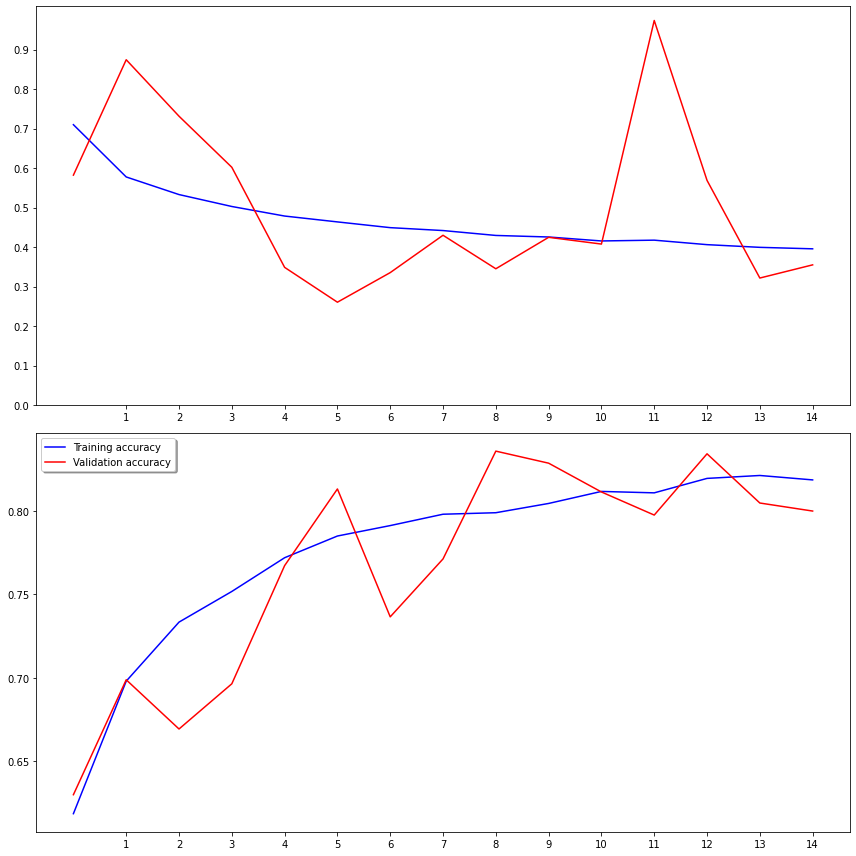

In [24]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 15, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 15, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()